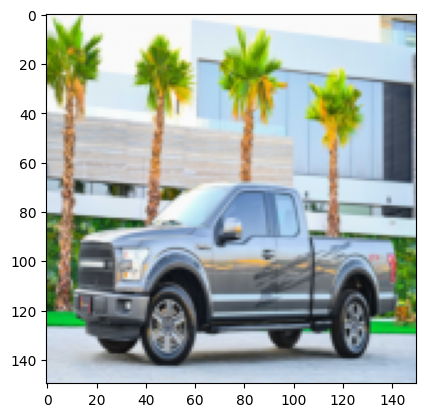

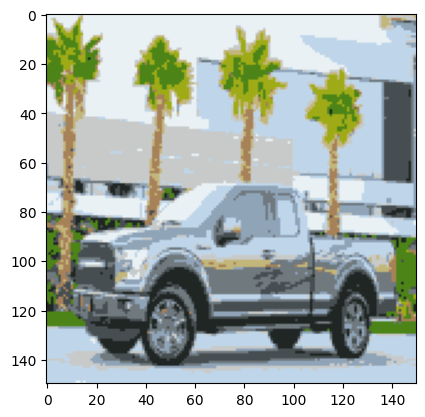

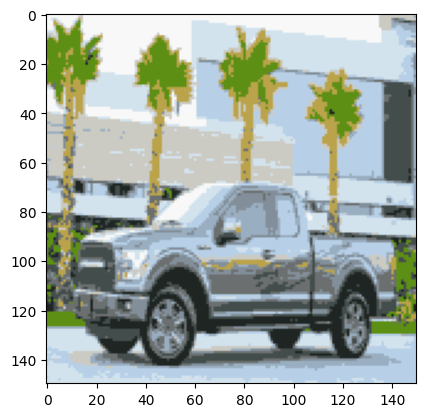

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage import io, transform

# Load and resize the image for faster processing
image = io.imread('/content/Truck.jpg')
resized_image = transform.resize(image, (150, 150))

# Display the original image
plt.figure('Original Image')
plt.imshow(resized_image)
plt.show()


def extract_feature_space(image, d):
    m, n = image.shape[0:2]
    hsv_image = colors.rgb_to_hsv(image)
    num_points = m * n
    if d == 1:
        im_space = hsv_image[..., 2]  # Intensity
    elif d == 2:
        im_space = hsv_image[..., 0:2]  # Hue and Saturation
    elif d == 3:
        im_space = image  # RGB
    else:
        raise ValueError('Not supported feature dimension')

    feature_vector = np.reshape(im_space, (num_points, d)).T
    return feature_vector

def extract_segmented_image(clustering_out, clusters, image):
    m, n = image.shape[0:2]
    d, k = clusters.shape[0:2]
    clusterd_feature_space = np.zeros((len(clustering_out), clusters.shape[0])).T

    for c in range(k):
        idxs = np.where(clustering_out == c)
        for j in idxs[0]:
            clusterd_feature_space[:, j] = clusters[:, c]

    im_space = np.reshape(clusterd_feature_space.T, (m, n, d))

    if d == 1:
        im_space = im_space[..., 0]
        segmented_image = im_space
    elif d == 2:
        hsv_image = colors.rgb_to_hsv(image)
        hsv_image[..., 0:2] = im_space
        hsv_image[..., 2] /= np.max(hsv_image[..., 2])
        segmented_image = colors.hsv_to_rgb(hsv_image)
    else:
        segmented_image = im_space

    return segmented_image


def kmeans(image, k, num_iterations, d):
    m, n = image.shape[0:2]
    num_points = m * n
    feature_space = extract_feature_space(image, d)

    # Initialize centroids with K-means++ method
    centroids = [feature_space[:, np.random.randint(num_points)]]
    for _ in range(1, k):
        distances = np.array([min(np.sum((x - c) ** 2) for c in centroids) for x in feature_space.T])
        probabilities = distances / np.sum(distances)
        next_centroid_index = np.random.choice(num_points, p=probabilities)
        centroids.append(feature_space[:, next_centroid_index])

    clusters_centers = np.array(centroids).T
    distance = np.zeros((k, 1))
    cluster_points = np.zeros((num_points, 1))

    for j in range(num_iterations):
        # Assign each point to the nearest cluster
        for l in range(num_points):
            for h in range(k):
                distance[h] = np.sqrt(np.sum((feature_space[:, l] - clusters_centers[:, h]) ** 2))
            cluster_points[l] = np.argmin(distance)

        # Update cluster centers
        for c in range(k):
            idxs = np.where(cluster_points == c)
            points = feature_space[:, idxs[0]]
            if points.size > 0:
                clusters_centers[:, c] = np.mean(points, axis=1)
            else:
                idx = np.random.randint(num_points)
                clusters_centers[:, c] = feature_space[:, idx]

    segmented_image = extract_segmented_image(cluster_points, clusters_centers, image)
    return segmented_image


# Test the K-means++ segmentation with 11 clusters and 50 iterations
segmented_image = kmeans(resized_image, k=11, num_iterations=50, d=3)

# Display the segmented image
plt.figure('Segmented Image (K-means++)')
plt.imshow(segmented_image)
plt.show()


def kmeans_uniform(image, k, num_iterations, d):
    m, n = image.shape[0:2]
    num_points = m * n
    feature_space = extract_feature_space(image, d)

    # Initialize centroids using uniform distribution of indices
    idxs = np.linspace(0, num_points - 1, k, dtype=int)
    clusters_centers = feature_space[:, idxs]

    distance = np.zeros((k, 1))
    cluster_points = np.zeros((num_points, 1))

    for j in range(num_iterations):
        for l in range(num_points):
            for h in range(k):
                distance[h] = np.sqrt(np.sum((feature_space[:, l] - clusters_centers[:, h]) ** 2))
            cluster_points[l] = np.argmin(distance)

        for c in range(k):
            idxs = np.where(cluster_points == c)
            points = feature_space[:, idxs[0]]
            if points.size > 0:
                clusters_centers[:, c] = np.mean(points, axis=1)
            else:
                idx = np.random.randint(num_points)
                clusters_centers[:, c] = feature_space[:, idx]

    segmented_image = extract_segmented_image(cluster_points, clusters_centers, image)
    return segmented_image

# Test the uniform initialization method
segmented_image_uniform = kmeans_uniform(resized_image, k=11, num_iterations=50, d=3)
plt.figure('Segmented Image (Uniform Init)')
plt.imshow(segmented_image_uniform)
plt.show()

